# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
#  Reading the Data to a variable
df = pd.read_csv("TeslaInc. ( TSLA ).csv", index_col="Date", 
                 infer_datetime_format=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500


In [4]:
# Basic statistical info of the data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3077.000000,3077.000000,3077.000000,3077.000000,3077.000000,3.077000e+03
mean,55.502174,56.748047,54.161176,55.495537,55.495537,9.340392e+07
std,93.913081,96.085026,91.517219,93.851345,93.851345,8.235816e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,8.192667,8.354667,7.970667,8.113333,8.113333,4.144350e+07
50%,15.983333,16.242001,15.687333,16.000668,16.000668,7.541550e+07
75%,23.586666,23.916668,23.229334,23.523333,23.523333,1.173030e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


# Exploratory Data Analysis

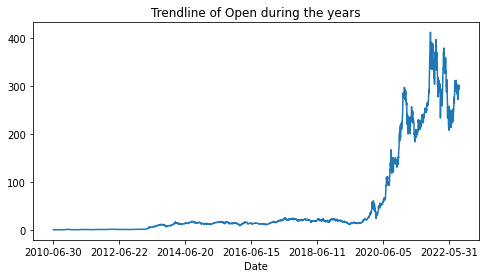

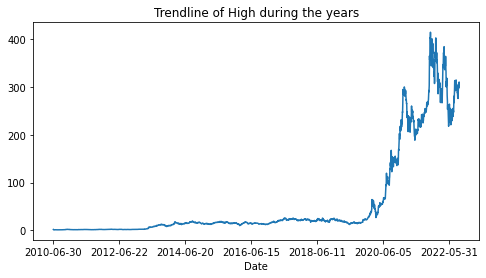

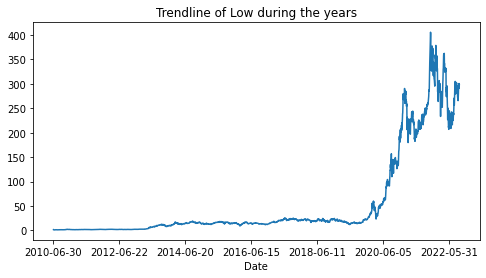

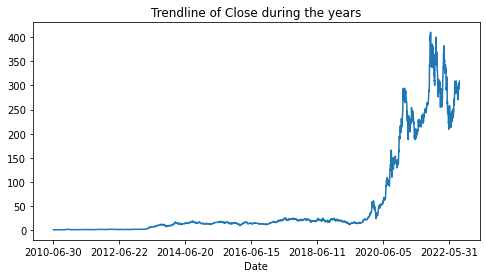

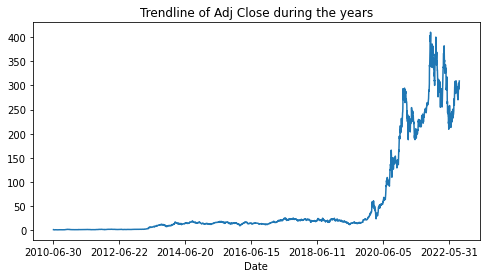

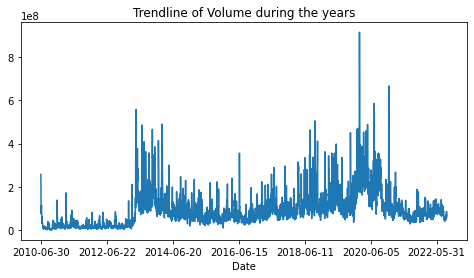

In [5]:
for i in df.columns:
    plt.figure()
    df[i].plot(figsize=(8,4), title="Trendline of {} during the years".format(i))

Text(0.5, 1.0, 'Correlation b/w the values')

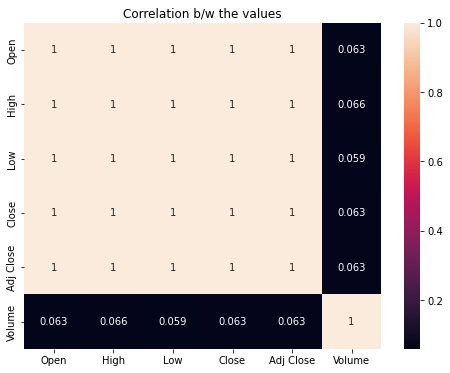

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation b/w the values")

<AxesSubplot:xlabel='Date'>

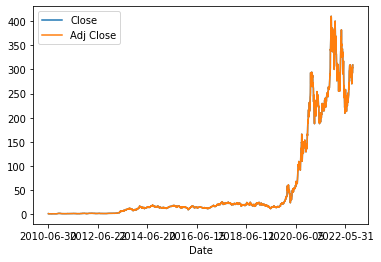

In [7]:
df[["Close", "Adj Close"]].plot() # Concludes that Close and Adj Close columns are identical

In [8]:
(df["Close"] - df["Adj Close"]).max()

0.0

Text(0.5, 1.0, 'Joint plot of two columns Open & Close')

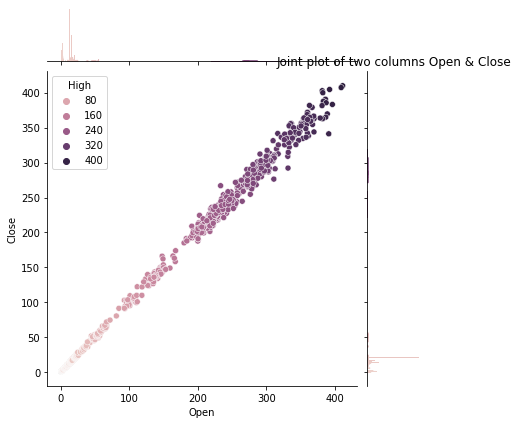

In [9]:
sns.jointplot(x = df["Open"], y=df["Close"], hue=df["High"])
plt.title("Joint plot of two columns Open & Close")

<AxesSubplot:xlabel='Date'>

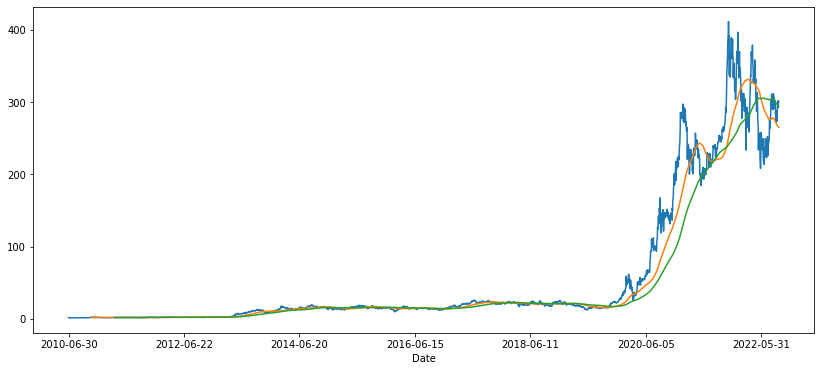

In [10]:
plt.figure(figsize=(14,6))
df.Open.plot(label="Open price trend")
df.Open.rolling(100).mean().plot(label="100 Moving Average")
df.Open.rolling(200).mean().plot(label="100 Moving Average")

# Pre Processing

In [11]:
len(df) # Length of the DataFrame

3077

#### I want to predict just the "Open" column, hence I'll drop the rest of the columns.

In [12]:
df.drop(["High", "Close", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

In [13]:
# Taking 70% of the data as the trainig & rest 30% as the testing set.
train = df[:int(len(df) * .7 )]
test = df[int(len(df) * .7 ):]

train.shape, test.shape

((2153, 1), (924, 1))

In [14]:
# Scaling down the data between the range 0 and 1.
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train)
# Fitting only the training data to avoid data leakage.

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
# Splitting the data into x and y (For training data only)

x_train = []
y_train = []
for i in range(100, scaled_train.shape[0]):
    x_train.append(scaled_train[i-100:i])
    y_train.append(scaled_train[i,0])
    

In [16]:
# Converting the x and y training data into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [414]:
x_train.shape

(2053, 100, 1)

# Making the Model.

In [17]:
n_features = 1 # As the number of columns in the data is 1 i.e the Open column

model = Sequential()

model.add(LSTM(64, activation="relu", input_shape=(x_train.shape[1], n_features), return_sequences=True))

model.add(LSTM(78, activation="relu", return_sequences=True))

# The above two LSTM layers has the parameter 'return_sequences' set to 'True as the model is having stacked LSTM layers.

model.add(LSTM(24, activation="relu"))
model.add(Dropout(0.2)) # Turns off 20% of the neurons to avoid over training.

model.add(Dense(1)) # Only 1 neuron for dense layer as the model should have only 1 continuous output.
model.compile(optimizer="adam", loss="mse")

In [18]:
model.summary() # Summary of the model 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 78)           44616     
                                                                 
 lstm_2 (LSTM)               (None, 24)                9888      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
_________________________________________________________________


# Fitting the model

In [19]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
65/65 [==============================] - 22s 262ms/step - loss: 0.0626
Epoch 2/10
65/65 [==============================] - 18s 279ms/step - loss: 0.0116
Epoch 3/10
65/65 [==============================] - 18s 275ms/step - loss: 0.0095
Epoch 4/10
65/65 [==============================] - 18s 280ms/step - loss: 0.0082
Epoch 5/10
65/65 [==============================] - 19s 290ms/step - loss: 0.0083
Epoch 6/10
65/65 [==============================] - 18s 283ms/step - loss: 0.0079
Epoch 7/10
65/65 [==============================] - 18s 285ms/step - loss: 0.0075
Epoch 8/10
65/65 [==============================] - 19s 286ms/step - loss: 0.0081
Epoch 9/10
65/65 [==============================] - 19s 292ms/step - loss: 0.0068
Epoch 10/10
65/65 [==============================] - 20s 304ms/step - loss: 0.0065


<AxesSubplot:>

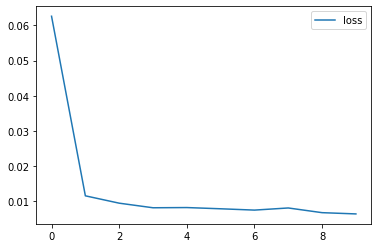

In [20]:
losses = pd.DataFrame(model.history.history) # Coverting the history of losses of the model into a dataframe.
losses.plot() # Plotting the losses

In [21]:
# Taking last 100 days to predict the first testing value and then so on. 
past_100_days = train.tail(100)
final_df = past_100_days.append(test, ignore_index=True)

In [25]:
len(final_df) # Length of the final data frame.

1024

In [23]:
inp = scaler.fit_transform(final_df) # Transforming the new input data.

In [504]:
# Splitting into x and y (For Testing set)
x_test = []
y_test = []

for i in range(100, inp.shape[0]):
    x_test.append(inp[i-100:i])
    y_test.append(inp[i,0])

In [505]:
# Converting testing data into numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Predicting

In [507]:
prediction = model.predict(x_test)


In [508]:
scaler.scale_

array([0.00250378])

In [509]:
scaling_factor = 1 / 0.00250378

# Multiplying predictions and y test values with scaling factor to get the original values back. 

prediction = prediction * scaling_factor
y_test = y_test * scaling_factor

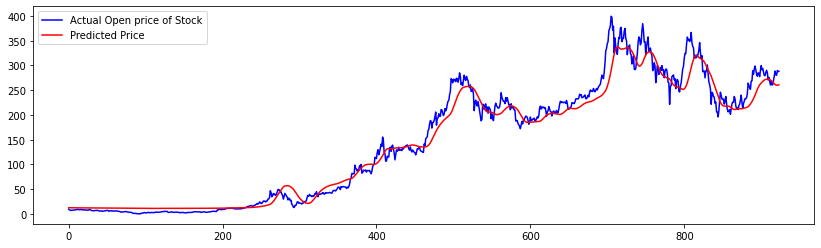

In [552]:
# Plotting our y test and Predictions.

plt.figure(figsize=(14,4))
plt.plot(y_test, "b", label = "Actual Open price of Stock")
plt.plot(prediction, "r", label = "Predicted Price")
plt.legend()


In [511]:
# Calculating RMSE 
print(np.sqrt(mean_squared_error(y_test, prediction)))

21.623028006202276


In [512]:
# Saving the Model.
model.save("stockPred.h5")